In [1]:
#i am a monitor notebook used to prototype on the fly >.<
#i should be replaced with a proper dashboard,srsly.
#right now i show some logs of mastering pong with a2c

### Run stuff

In [1]:
%%bash --bg
#create several player processes. Each process plays games and saves results
#the loop below spawns 10 players. If you are doing this on a laptop, reducing to 2-4 is okay
for i in `seq 1 10`; 
do
        THEANO_FLAGS=device=cpu,floatX=float32 python tinyverse atari.py play -b 3 &
done  

Starting job # 0 in a separate thread.


In [2]:
%%bash
#play 5 games, show results
python tinyverse atari.py eval -n 5

Episode finished after 125 timesteps with reward=0.0
Episode finished after 124 timesteps with reward=0.0
Episode finished after 246 timesteps with reward=3.0
Episode finished after 155 timesteps with reward=1.0
Episode finished after 172 timesteps with reward=1.0


tinyverse/database.py:150: UserWarning: Params not found under key 'weights' (got None)
  warn(str(exc))
[2017-01-16 20:31:02,464] Making new env: BreakoutDeterministic-v0
[2017-01-16 20:31:02,517] Clearing 6 monitor files from previous run (because force=True was provided)
[2017-01-16 20:31:02,530] Starting new video recorder writing to /home/hedgedir/tinyversers/ezheverse/records/openaigym.video.0.22324.video000000.mp4
[2017-01-16 20:31:03,633] Starting new video recorder writing to /home/hedgedir/tinyversers/ezheverse/records/openaigym.video.0.22324.video000001.mp4
[2017-01-16 20:31:09,093] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/hedgedir/tinyversers/ezheverse/records')


In [3]:
%%bash --bg
#create learner process on GPU. batch size 10
THEANO_FLAGS=device=gpu,floatX=float32 python tinyverse atari.py train -b 10 &

Starting job # 2 in a separate thread.


### View stuff

In [2]:
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline
import theano
import theano.tensor as T
import pickle


In [3]:
import atari
from tinyverse.database import Database
from agentnet.environment.session_batch import SessionBatchEnvironment


db = Database()
self=experiment=atari.make_experiment(db)
agent = self.agent


observation_shape=(1, 64, 64)  # same as env.observation_space.shape
sequence_length=25  # how many steps to make before updating weights

#make replay environment
observations = T.tensor(theano.config.floatX,broadcastable=(False,)*(2+len(observation_shape)),
                        name="observations[b,t,color,width,height]")
actions = T.imatrix("actions[b,t]")
rewards,is_alive = T.matrices("rewards[b,t]","is_alive[b,t]")
prev_memory = [l.input_var for l in agent.agent_states.values()]



replay = SessionBatchEnvironment(observations,
                                 [observation_shape],
                                 actions=actions,
                                 rewards=rewards,
                                 is_alive=is_alive,
                                 preceding_agent_memories=prev_memory
                                )

#replay sessions
_, _, h_seq, _, (logits_seq, V_seq) = agent.get_sessions(
    replay,
    session_length=sequence_length,
    experience_replay=True,
    unroll_scan=False,#speeds up compilation my 10x, slows down training by 20% (still faster than TF :P )
)
rng_updates = agent.get_automatic_updates()

# compute pi(a|s) and log(pi(a|s)) manually [use logsoftmax]
# we can't guarantee that theano optimizes logsoftmax automatically since it's still in dev
logits_flat = logits_seq.reshape([-1,logits_seq.shape[-1]])
policy_seq = T.nnet.softmax(logits_flat).reshape(logits_seq.shape)
logpolicy_seq = T.nnet.logsoftmax(logits_flat).reshape(logits_seq.shape)

#####################
import lasagne
from agentnet.learning import a2c
# get policy gradient
elwise_actor_loss,elwise_critic_loss = a2c.get_elementwise_objective(policy=logpolicy_seq,
                                                                     treat_policy_as_logpolicy=True,
                                                                     state_values=V_seq[:,:,0],
                                                                     actions=replay.actions[0],
                                                                     rewards=replay.rewards,
                                                                     is_alive=replay.is_alive,
                                                                     gamma_or_gammas=0.99,
                                                                     n_steps=None,
                                                                     n_steps_advantage=1,
                                                                     return_separate=True)


reg_entropy = 1e-2*T.mean(T.sum(policy_seq*logpolicy_seq,axis=-1))
loss = elwise_actor_loss.mean() + 0.25*elwise_critic_loss.mean() + reg_entropy


# Compute weight updates
dV,dl = T.grad(-loss,[V_seq,logits_seq])
#####################



# compile train function
inputs = [observations, actions, rewards, is_alive]+prev_memory
eval_fun = theano.function(inputs, 
                           [policy_seq, V_seq,dV,logits_seq,dl],
                           updates=rng_updates,on_unused_input='ignore')



/home/hedgedir/agentnet/agentnet/agent/recurrence.py:595: UserWarning: Warning: recurrent loop without unroll_scan got nonempty random state updates list. That happened because there is some source of randomness (e.g. dropout) inside recurrent step graph. To compile such graph, one must either call .get_automatic_updates() right after .get_output and pass these updates to a function, or use no_defalt_updates=True when compiling theano.function.
  warn("Warning: recurrent loop without unroll_scan got nonempty random state updates list. That happened"
WARNING (theano.tensor.blas): We did not found a dynamic library into the library_dir of the library we use for blas. If you use ATLAS, make sure to compile it with dynamics library.
[2017-01-17 07:39:42,515] We did not found a dynamic library into the library_dir of the library we use for blas. If you use ATLAS, make sure to compile it with dynamics library.


In [4]:
import gym
avg_reward_per_session = []
gym.make("PongDeterministic-v0").get_action_meanings()

[2017-01-17 07:41:10,388] Making new env: PongDeterministic-v0


['NOOP', 'FIRE', 'RIGHT', 'LEFT', 'RIGHTFIRE', 'LEFTFIRE']

n_sessions: 5103


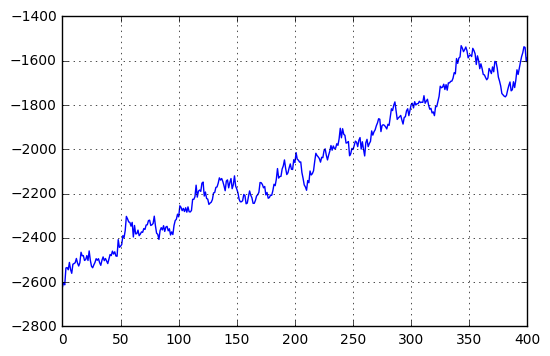

r	V		Ent	Logits
+0.0 -1.466 (-0.879) +1.701 | +0.18(-0.29) -0.10(+0.05) +0.38(+0.08) -0.50(+0.04) +0.62(+0.10) -0.61(+0.03)
+0.0 -1.572 (-0.705) +1.591 | -0.01(+0.04) -0.23(+0.03) +0.66(+0.07) -0.69(+0.02) +0.99(-0.18) -0.71(+0.02)
+0.0 -1.654 (-0.579) +1.453 | +0.02(+0.01) -0.22(+0.01) +1.17(+0.02) -0.91(-0.07) +1.16(+0.02) -1.21(+0.01)
+0.0 -1.690 (-0.547) +1.431 | -0.22(+0.00) -0.14(+0.00) +1.06(+0.00) -0.89(+0.00) +1.32(-0.01) -1.10(+0.00)
+0.0 -1.704 (-0.558) +1.744 | -0.52(+0.04) -0.39(+0.05) +0.02(+0.07) +0.35(+0.09) +0.28(-0.34) +0.23(+0.09)
+0.0 -1.831 (-0.345) +1.132 | -0.62(-0.01) -0.54(-0.01) -1.17(-0.01) +2.00(+0.14) -1.18(-0.01) +1.36(-0.11)
+0.0 -1.759 (-0.530) +0.997 | +0.06(+0.00) -0.70(+0.00) -1.17(+0.00) +2.32(-0.01) -1.63(+0.00) +0.90(+0.00)
+0.0 -1.771 (-0.546) +1.744 | +0.16(+0.25) -0.41(+0.15) +0.14(+0.25) +0.49(-0.99) -0.22(+0.17) -0.24(+0.17)
+0.0 -2.127 (+0.125) +1.774 | +0.13(+0.37) -0.17(-0.06) -0.02(-0.07) +0.32(-0.11) -0.21(-0.06) -0.09(-0.07)
+0.0 -2.034 

In [ ]:
#MEGA-controller of doom. Draws all the stuff i wanted to see for some reason. Don't try to analize
from IPython.display import clear_output
while True:
    if db.redis.exists("weights"):
        weights = db.loads(db.redis.get('weights'))
        if any(map(np.any,map(np.isnan,weights))):
            print("Weights broken!!!")
    
    print("n_sessions:",db.redis.llen("sessions"))
    plt.plot(avg_reward_per_session)
    plt.grid()
    plt.show()
    
    
    from scipy.stats import entropy
    db.load_all_params(experiment.agent,errors='raise')
    s,a,r,alive,mem = db.loads(db.redis.lindex('sessions',np.random.randint(1000)))

    pi,v,dv,logits,dlogits = eval_fun([s],[a],[r],[alive],*[m[None] for m in mem])
    
    print ("r\tV\t\tEnt\tLogits")
    for lo_i,dlo_i,pi_i,v_i,dv_i,r_i in zip(
        logits.reshape(-1,6),
        dlogits.reshape(-1,6),
        pi.reshape(-1,6),
        v.reshape(-1),
        dv.reshape(-1),
        r.reshape(-1)):
        logit_str = map(lambda l,dl:("%+.2f(%+.2f)"%(l,100*dl)),lo_i,dlo_i)
        print ("%+.1f"%r_i, "%+.3f"%v_i,"(%+.3f)"%(100*dv_i),"%+.3f"%entropy(pi_i),"|"," ".join(logit_str))
    

    R=0
    for i in range(5000)[::-1]:
        s,a,r,d,m = db.loads(db.redis.lindex('sessions',i))
        R += sum(r)
    avg_reward_per_session.append(R)
    clear_output(True)
    

In [13]:
from lasagne.updates import total_norm_constraint
x,y = T.matrices("XY")
xc,yc = total_norm_constraint([x,y],10)

In [ ]:
theano.function(xc,yc)

In [99]:
from scipy.signal import lfilter
#s,a,r,alive,mem = pickle.loads(db.redis.lindex('sessions',np.random.randint(1000)))
pi,v,dv,logits,dlogits = eval_fun([s],[a],[r],[alive],*[m[None] for m in mem])
vv = v[:,:,0]
rr = r[None,:]
gamma=0.99


In [104]:
from agentnet.learning.generic import get_n_step_value_reference

observed_state_values = get_n_step_value_reference(
        state_values=T.constant(vv),
        rewards=T.constant(rr),
        n_steps=None,
        gamma_or_gammas=0.99,
    )
adv_an = (observed_state_values.eval() - vv)[0]

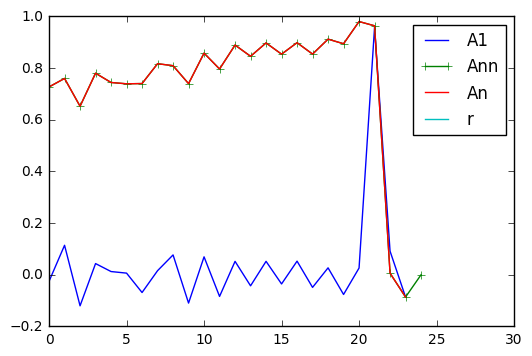

In [107]:
adv_1_step = rr[:,:-1]+gamma*vv[:,1:] - vv[:,:-1]

def discount(x, gamma):
    return lfilter([1], [1, -gamma], x[::-1], axis=0)[::-1]

plt.plot(adv_1_step[0],label='A1')
plt.plot(adv_an,label='Ann',marker='+')
plt.plot(discount(adv_1_step[0],0.99),label='An')
plt.plot(r[0],label='r')
plt.xlim(0,30)
plt.legend(loc='best')

(210, 160, 3)

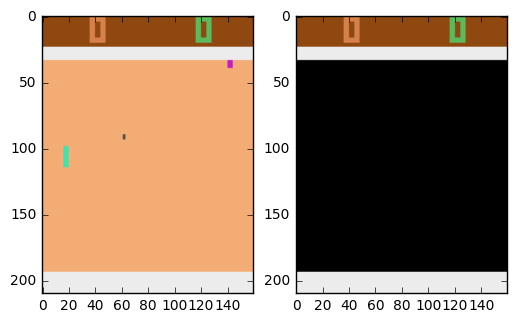

In [49]:

plt.subplot(1,2,1)
plt.imshow(img)
plt.subplot(1,2,2)
img[34:34+160,:160] =0
plt.imshow(img)
img.shape

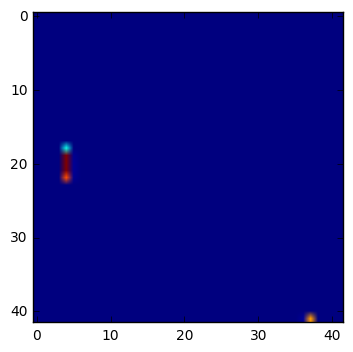

In [27]:
plt.imshow(mem[0][3,0])

In [18]:
!ps aux | grep tinyverse

root      6326 90.6  0.7 79039712 928644 pts/11 Rl+ 06:42   0:44 python tinyverse atari.py train -b 10
root      6475 90.9  0.2 71643972 347380 pts/8 Rl   06:42   0:28 python tinyverse atari.py play -b 1
root      6476 87.8  0.2 71643852 348072 pts/8 Rl   06:42   0:27 python tinyverse atari.py play -b 1
root      6477 89.0  0.2 71643968 349932 pts/8 Rl   06:42   0:27 python tinyverse atari.py play -b 1
root      6478 87.4  0.2 71643552 347084 pts/8 Rl   06:42   0:27 python tinyverse atari.py play -b 1
root      6479 87.4  0.2 71643540 354384 pts/8 Rl   06:42   0:27 python tinyverse atari.py play -b 1
root      6480 84.1  0.2 71643848 347368 pts/8 Rl   06:42   0:26 python tinyverse atari.py play -b 1
root      6481 91.0  0.2 71643512 349676 pts/8 Rl   06:42   0:28 python tinyverse atari.py play -b 1
root      6482 87.4  0.2 71643512 347188 pts/8 Sl   06:42   0:27 python tinyverse atari.py play -b 1
root      6483 86.0  0.2 71643848 348648 pts/8 Rl   06:42   0:26 python tinyverse atari.p

In [23]:
!kill -9 $(ps aux | grep tinyverse | awk '{print $2}') #uncomment to hard kill all
from tinyverse.database import Database
db = Database()
for key in db.redis.keys():
    db.redis.delete(key)

In [16]:
db.redis.delete("weights")

0